## 5) Trying to capture the real world within a model


#  Fastscape Example 1: Grapevine Mountain Fans in Death Valley

<img src="./03images/GrapevineGoogleEarth.jpg" width="1000">

In [5]:
%load_ext xsimlab.ipython
import numpy as np
import xsimlab as xs
import xarray as xr
import matplotlib.pyplot as plt
import zarr

import GSFast_Gravel 

The xsimlab.ipython extension is already loaded. To reload it, use:
  %reload_ext xsimlab.ipython


In [6]:
from fastscape.models import sediment_model
from fastscape.processes import (MultipleFlowRouter)

from fastscape.processes import (Bedrock)
from fastscape.processes import StratigraphicHorizons

from GSFast_Gravel import GravelGSN

model = sediment_model.update_processes({'flow': MultipleFlowRouter,
                                         'bedrock':Bedrock,
                                         'strati': StratigraphicHorizons,
                                         'gsize': GravelGSN 
                                        })

In [7]:
# %create_setup model --default --verbose

Spatial Constraints (and their Impact on the model)

## 3) Spatial Set Up (Bounding Conditions)

To solve a Partial Differential Equation (PDE) as the one shown above, one also needs to specify the geometry of the problem and, most importantly, boundary conditions. In FastScape, the PDE is solved in a rectangular domain of dimensions $L_x\times L_y$ which is discretized using a rectangular (regular) discretization of $n_x\times n_y$ points or *nodes*.

<img src="./03images/Mesh.jpg" width="500">



## Sptial Constraints on the model set-up can impact:
1) Erosion/deposition rates, 
2) sedimentfluxes and steady-state times
3) Topography
4) channel dynamics
5) Basically everything


In [113]:
#Real World Data
MeanFanorCatchmentWidth=2.7e3 #meters
NumberofFansorCatchments=8
wm = 17e3 # width of the mountain (in m)
wb = 7e3 # with of the basin (in m)
CellSize=100 #Width of larger channels #m
Boundary=['core','fixed_value','looped','looped']


#Convert this to model Inputs
xl = wm+wb # xl, length of the grid in the x-direction 
yl = MeanFanorCatchmentWidth*NumberofFansorCatchments # yl, length of the mesh in the y-direction 
nx=int(xl/CellSize)+1 #(ranges between 2 (over 20 for channel dynamics) to ~1000.)
ny=int(yl/CellSize)+1 #(ranges between 2(over 20 for channel dynamics) to ~1000.)
x, y = np.meshgrid(np.linspace(0,xl,nx), np.linspace(0,yl,ny)) # creates an x,y mesh

print('Min. Number of Cells Across basin, down basin, or down mountain', int(np.min([wb,wm,yl])/(CellSize)))
print('2D Channel dynamics in the basin are possible',np.where(int(np.min([wb,yl])/(CellSize)>20),'True','False'))
print('The grid cells are square',(x[0,0:2])==(y[0:2,0]))

Min. Number of Cells Across basin, down basin, or down mountain 70
2D Channel dynamics in the basin are possible True
The grid cells are square [ True  True]


<img src="./03images/SpatialDrainage.png" width="500">

#Notes
#Grid cells need to be square.
#If you want channel dynamics that converge to a similar solution and aren't as impacted by the boundary
#then choose preferably over ~20 cells down and across the basin. Adjust your cell size to meet this requirement.
#Otherwise you are moving towards a 1D sheet flow or a boundary influenced solution.

#The initial topography can influence your solutions (consider this when you are trying to compare simulations).

Temporal Constraints

In [9]:
tf=18e6 #duration of fault activity
timestepbtw_simulation= 10000 #ranges between 1000-50000 year time scales. #No set rule for this.
ntime=int(tf/timestepbtw_simulation)+1
timestepbtw_output=100000
nout=int(tf/timestepbtw_output)+1
print('Number of time steps:',tf/timestepbtw_simulation)

Number of time steps: 1800.0


In [10]:
nout

181

Uplift and Subsidence (Imposed and well known)

In [11]:
# Uplift
s0=0.0005
u0=s0*2/3# 0.0001666-0.0003333 (one to two thirds the subsidence rate)
alpha=2.2 #2-2.5 #increase alpha since I made the basin longer
U = xr.DataArray(np.where(x<wm, u0, -s0*np.exp(-(x-wm)/wb*alpha)),dims=['y','x'])


Initial Topography

FastScape also needs an initial condition, i.e.:

$$h(t=0)=h_0(x,y)$$

which is commonly assumed to be a very small white noise (i.e. of amplitude = 1 m).

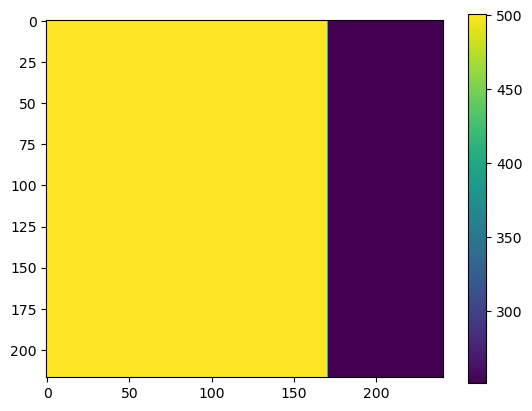

In [12]:
#How much initial topography would their be from a first (2e6) phase of sporadic uplift
SporaticUplift=np.linspace(0.0001, 0.0004, num=10)*100e3 #uplift times the time period.
Baselevel=250
#Initial Topography
h0 = np.ones([ny,nx]) + np.where(x>wm,Baselevel, Baselevel+np.sum(SporaticUplift)) 
plt.imshow(h0)
plt.colorbar()

model=model.drop_processes('init_topography')


In [47]:
# %create_setup model --default --verbose

In [48]:
# Additional Considerations

In [49]:
# Diffusion 

- Hillslope Diffusion impacts most the orogenic area. 
- It chages the interfluves between the channel areas
- Hillslope diffusion is an additional erosional term after the stream power law that erodes based on the curvature rather than slope.
- Hillslope diffusion is highly sensitive to cell size and area. This is because the greater the cell size, the lower the slope and change in slope. 
- Generally, hillslope diffusion 3e-3 m^2yr^1 at the 10 m scale based on Braun et al. (2001) (10.1130/0091-7613(2001)029<0683:STMOSM>2.0.CO;2). Bump up diffusitivty coefficent an order of magnitude for each change in grid magnitude. Cell=100m then diffusivity=3e-2. This compensates for the impact of grid spacing and smooting on slopes. 

<img src="./03images/Diffusivehill.png" width="500">

In [96]:
# %create_setup model --default --verbose


In [48]:
# %create_setup model --default --verbose
import xsimlab as xs

ds_in = xs.create_setup(
    model=model,
    clocks={'time': np.linspace(0,tf,ntime),
           'out': np.linspace(0,tf,nout),
            'out2': np.linspace(tf-timestepbtw_output,tf,1)},
    master_clock = 'time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [ny,nx],
        # total grid length in (y, x)
        'grid__length': [yl,xl],
        # node status at borders
        'boundary__status': Boundary,
        # uplift rate
        'uplift__rate': U,
        # MFD partioner slope exponent
        'flow__slope_exp': 1.0,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # relative tolerance (Gauss-Siedel convergence)
        'spl__tol_rel': 0.0001,
        # absolute tolerance (Gauss-Siedel convergence)
        'spl__tol_abs': 0.0001,
        # max nb. of iterations (Gauss-Siedel convergence)
        'spl__max_iter': 100,
        # bedrock channel incision coefficient
        'spl__k_coef_bedrock': 2e-5,
        # soil (sediment) channel incision coefficient
        'spl__k_coef_soil': 2e-5, #higher k_f is generally more erodible. 
        # detached bedrock transport/deposition coefficient
        'spl__g_coef_bedrock': 1, #transport limited (G over 0.4 with sufficient sediment). Mediam 0.7 from Guerit et al. (2019)?
        # soil (sediment) transport/deposition coefficient
        'spl__g_coef_soil': 1,
        # bedrock diffusivity
        'diffusion__diffusivity_bedrock': 0, #varies depends on your spatial grid resolution! This will change your slopes between the channels in the mountain area. 
        #3e-3 m^2yr^1 at the 10 m scale. Bump up diffusitivty coefficent an order of magnitude for each change in grid magnitude. Cell=100m then diffusivity=3e-2.
        # soil (sediment) diffusivity
        'diffusion__diffusivity_soil': 0,
        # surface topography elevation
        'topography__elevation': h0,
        'strati__freeze_time': np.linspace(0,tf,nout),
        'gsize__D0': 1, 
        # The bedrock source grain size standard deviation
        'gsize__SD0': 0.75,
        # Cv (grain size calculation constant) described in Fedele and Paola (2007) and Duller
        # et al. (2010)
        'gsize__Cv': 0.75,
        # C1 (grain size calculation constant) described in Fedele and Paola (2007) and Duller
        # et al. (2010)
        'gsize__C1': 0.75,
        # Porosity
        'gsize__porosity': 0,
        
        
    },
    output_vars={'topography__elevation': 'out',
                 'bedrock__elevation': 'out',
                 'drainage__flowacc': 'out',
                 'erosion__rate': 'out',
                 'gsize__EFlux': 'out',
                 'gsize__Age': 'out',
                 "strati__elevation": "out2", #only need the final time step
                }
)


In [49]:
zgroup = zarr.group("DeathValleyMountain.zarr", overwrite=True)

In [50]:
with model, xs.monitoring.ProgressBar():
    ds_out = (ds_in.xsimlab.run(model=model, store=zgroup))

             0% | initialize 

In [210]:
zdataset = xr.open_zarr('DeathValleyMountain.zarr').set_index()

zdataset.x.attrs["units"] = "m"
zdataset.y.attrs["units"] = "m"
zdataset.out.attrs["units"] = "years"
zdataset.out2.attrs["units"] = "years"
startbasin=int(wm/CellSize)

aspects= 1#If 2, x direction will be twice as long as y. #xl/yl
sizes= 8

In [59]:
%config InlineBackend.figure_format = 'svg'

# Take a look at Variable Plots

In [60]:
#Take a look at basin 2
from ipyfastscape import TopoViz3d

app = TopoViz3d(zdataset, canvas_height=600, time_dim="out")

app.components['background_color'].set_color('lightgray')
app.components['vertical_exaggeration'].set_factor(5)
app.components['timestepper'].go_to_time(zdataset.out[-1])

app.show()

/Users/awild/opt/anaconda3/envs/workshop-itn-potsdam-2023-01/lib/python3.10/site-packages/ipyfastscape/xr_accessor.py:73: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return self._dataset.indexes[self.time_dim].get_loc(time, method='nearest')


Output(layout=Layout(height='640px'))

In [91]:
#Take a look at basin 2
from ipyfastscape import TopoViz3d

app = TopoViz3d(zdataset.isel(x=slice(int(wm/CellSize),-1)), canvas_height=600, time_dim="out")

app.components['background_color'].set_color('lightgray')
app.components['vertical_exaggeration'].set_factor(5)
app.components['timestepper'].go_to_time(zdataset.isel(x=slice(int(wm/CellSize),-1)).out[-1])

app.show()

/Users/awild/opt/anaconda3/envs/workshop-itn-potsdam-2023-01/lib/python3.10/site-packages/ipyfastscape/xr_accessor.py:73: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return self._dataset.indexes[self.time_dim].get_loc(time, method='nearest')


Output(layout=Layout(height='640px'))

# Calculate Fluxes

In [15]:
#To get flux per year divide by the timestep between your simulations
Flux=zdataset.gsize__EFlux/timestepbtw_simulation

In [16]:
# Calculate the mean flux leaving the mountain front at steady-state
Flux.isel(x=int(wm/CellSize)).isel(out=slice(-int(nout*1/4),-1)).mean('y').mean('out').values

array(0.00032627)

In [17]:
#Recall at steady-state that this should be near (not excat) to uplift rate
u0

0.0003333333333333333

In [18]:
#select the flux in the dominant channel
#
#select the main channel
max_drainage_indices = xr.DataArray(zdataset.drainage__flowacc.argmax('y')).load()
ChannelTopo=zdataset.topography__elevation.sel(y=zdataset.y[max_drainage_indices]);
ChannelFlux=Flux.sel(y=zdataset.y[max_drainage_indices]);

In [19]:
ChannelFlux

<xarray.DataArray 'gsize__EFlux' (out: 181, x: 241)>
dask.array<reshape, shape=(181, 241), dtype=float64, chunksize=(181, 241), chunktype=numpy.ndarray>
Coordinates:
  * out      (out) float64 0.0 1e+05 2e+05 3e+05 ... 1.78e+07 1.79e+07 1.8e+07
  * x        (x) float64 0.0 100.0 200.0 300.0 ... 2.38e+04 2.39e+04 2.4e+04
    y        (out, x) float64 0.0 0.0 0.0 0.0 ... 2.07e+04 2.07e+04 2.07e+04

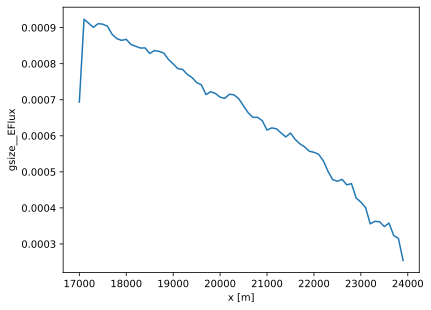

In [20]:
ChannelFlux.isel(out=slice(int((len(zdataset.out)-1)*1/4),-1)).mean('out').isel(x=slice(int(wm/CellSize),-1)).plot()

In [24]:
#ChannelFlux.isel(out=[-1,-10,-100]).isel(x=slice(int(wm/CellSize),-1)).plot.line(x='x')

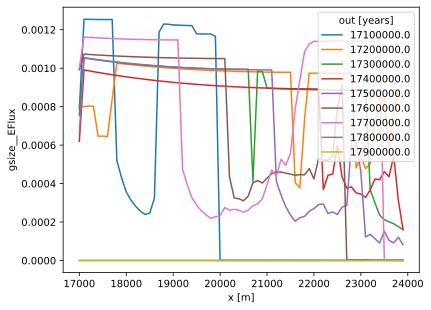

In [22]:
ChannelFlux.isel(out=slice(-10,-1)).isel(x=slice(int(wm/CellSize),-1)).plot.line(x='x')

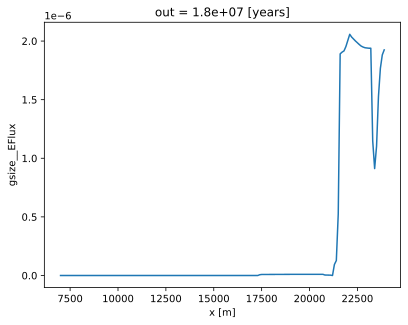

In [23]:
ChannelFlux.isel(out=-1).isel(x=slice(int(wb/CellSize),-1)).plot()

# Channel Mobility

In [81]:
#inputs needed:
drain2D_P20=zdataset.drainage__flowacc
Y_2D_P2=zdataset.y

In [82]:
#PREPARE TO run the function
max_drainage_indices = xr.DataArray(zdataset.drainage__flowacc.argmax('y')).load()
Binary=np.zeros_like(drain2D_P20)
DominantDrainage_YPath=drain2D_P20.argmax('y',skipna=True).to_numpy()

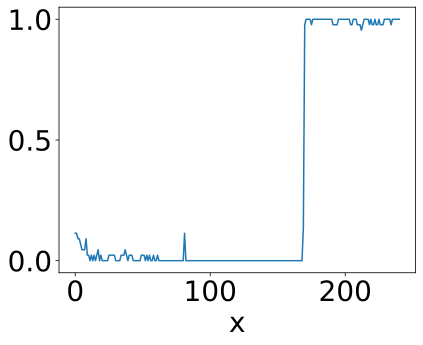

In [211]:
import DominantChannelDynamics as channel



a=xr.DataArray(channel.AvulsionMainChannel(Binary,DominantDrainage_YPath),dims=['time','y','x'])
sumAvulsion_overtimeperiod=a.max('y').isel(time=slice(-int(nout*1/4),-1)).sum('time')
timeInterval_minus1=int(nout*1/4)-1

AvulsionFrequency=sumAvulsion_overtimeperiod/timeInterval_minus1

AvulsionFrequency.plot()

# Local Minima

In [93]:
BasinTopo=zdataset.topography__elevation.isel(x=slice(int(wb/CellSize),-1))


In [146]:
DownBasinSlope=((BasinTopo.isel(x=slice(0,-2)).values)-(BasinTopo.isel(x=slice(1,-1)).values))/CellSize
BinaryMinima=xr.DataArray(np.where(DownBasinSlope<0.01,1,0),dims=['time','y','x'])
MinimaFrequency=BinaryMinima.sum('y').sum('time')/(len(zdataset.out)-1)/len(zdataset.y)

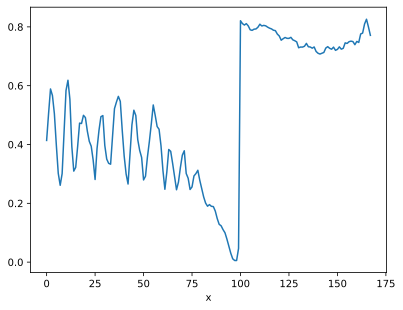

In [147]:
MinimaFrequency.plot()

# Adjust and rerun

In [157]:
tf=18e6 #duration of fault activity
timestepbtw_simulation= 10000/2 #ranges between 1000-50000 year time scales. #No set rule for this.
ntime=int(tf/timestepbtw_simulation)+1
timestepbtw_output=100000
nout=int(tf/timestepbtw_output)+1
print('Number of time steps:',tf/timestepbtw_simulation)

Number of time steps: 3600.0


In [159]:
s0*6/8

0.000375

In [160]:
# Uplift
s0=0.0005
u0=s0*6/8# 0.0001666-0.0003333 (one to two thirds the subsidence rate)
alpha=2.2 #2-2.5 #increase alpha since I made the basin longer
U = xr.DataArray(np.where(x<wm, u0, -s0*np.exp(-(x-wm)/wb*alpha)),dims=['y','x'])


In [161]:
# %create_setup model --default --verbose
import xsimlab as xs

ds_in = xs.create_setup(
    model=model,
    clocks={'time': np.linspace(0,tf,ntime),
           'out': np.linspace(0,tf,nout),
            'out2': np.linspace(tf-timestepbtw_output,tf,1)},
    master_clock = 'time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [ny,nx],
        # total grid length in (y, x)
        'grid__length': [yl,xl],
        # node status at borders
        'boundary__status': Boundary,
        # uplift rate
        'uplift__rate': U,
        # MFD partioner slope exponent
        'flow__slope_exp': 1.0,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # relative tolerance (Gauss-Siedel convergence)
        'spl__tol_rel': 0.0001,
        # absolute tolerance (Gauss-Siedel convergence)
        'spl__tol_abs': 0.0001,
        # max nb. of iterations (Gauss-Siedel convergence)
        'spl__max_iter': 100,
        # bedrock channel incision coefficient
        'spl__k_coef_bedrock': 1.5e-5,
        # soil (sediment) channel incision coefficient
        'spl__k_coef_soil': 2e-5, #higher k_f is generally more erodible. 
        # detached bedrock transport/deposition coefficient
        'spl__g_coef_bedrock': 0.7, #transport limited (G over 0.4 with sufficient sediment). Mediam 0.7 from Guerit et al. (2019)?
        # soil (sediment) transport/deposition coefficient
        'spl__g_coef_soil': 1,
        # bedrock diffusivity
        'diffusion__diffusivity_bedrock': 3e-2, #varies depends on your spatial grid resolution! This will change your slopes between the channels in the mountain area. 
        #3e-3 m^2yr^1 at the 10 m scale. Bump up diffusitivty coefficent an order of magnitude for each change in grid magnitude. Cell=100m then diffusivity=3e-2.
        # soil (sediment) diffusivity
        'diffusion__diffusivity_soil': 3e-2,
        # surface topography elevation
        'topography__elevation': h0,
        'strati__freeze_time': np.linspace(0,tf,nout),
        'gsize__D0': 1, 
        # The bedrock source grain size standard deviation
        'gsize__SD0': 0.75,
        # Cv (grain size calculation constant) described in Fedele and Paola (2007) and Duller
        # et al. (2010)
        'gsize__Cv': 0.75,
        # C1 (grain size calculation constant) described in Fedele and Paola (2007) and Duller
        # et al. (2010)
        'gsize__C1': 0.75,
        # Porosity
        'gsize__porosity': 0,
        
        
    },
    output_vars={'topography__elevation': 'out',
                 'bedrock__elevation': 'out',
                 'drainage__flowacc': 'out',
                 'erosion__rate': 'out',
                 'gsize__EFlux': 'out',
                 'gsize__Age': 'out',
                 "strati__elevation": "out2", #only need the final time step
                }
)


In [162]:
#zgroup = zarr.group("DeathValleyMountain2.zarr", overwrite=True)

In [163]:
with model, xs.monitoring.ProgressBar():
    ds_out = (ds_in.xsimlab.run(model=model, store=zgroup))

             0% | initialize 

In [206]:
zdataset = xr.open_zarr('DeathValleyMountain2.zarr').set_index()

zdataset.x.attrs["units"] = "m"
zdataset.y.attrs["units"] = "m"
zdataset.out.attrs["units"] = "years"
zdataset.out2.attrs["units"] = "years"
startbasin=int(wm/CellSize)

aspects= 1#If 2, x direction will be twice as long as y. #xl/yl
sizes= 8

In [207]:
#Take a look at basin 2
from ipyfastscape import TopoViz3d

app = TopoViz3d(zdataset, canvas_height=600, time_dim="out")

app.components['background_color'].set_color('lightgray')
app.components['vertical_exaggeration'].set_factor(5)
app.components['timestepper'].go_to_time(zdataset.out[-1])

app.show()

/Users/awild/opt/anaconda3/envs/workshop-itn-potsdam-2023-01/lib/python3.10/site-packages/ipyfastscape/xr_accessor.py:73: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return self._dataset.indexes[self.time_dim].get_loc(time, method='nearest')


Output(layout=Layout(height='640px'))

In [155]:
#Take a look at basin 2
from ipyfastscape import TopoViz3d

app = TopoViz3d(zdataset.isel(x=slice(int(wm/CellSize),-1)), canvas_height=600, time_dim="out")

app.components['background_color'].set_color('lightgray')
app.components['vertical_exaggeration'].set_factor(5)
app.components['timestepper'].go_to_time(zdataset.isel(x=slice(int(wm/CellSize),-1)).out[-1])

app.show()

/Users/awild/opt/anaconda3/envs/workshop-itn-potsdam-2023-01/lib/python3.10/site-packages/ipyfastscape/xr_accessor.py:73: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return self._dataset.indexes[self.time_dim].get_loc(time, method='nearest')


Output(layout=Layout(height='640px'))

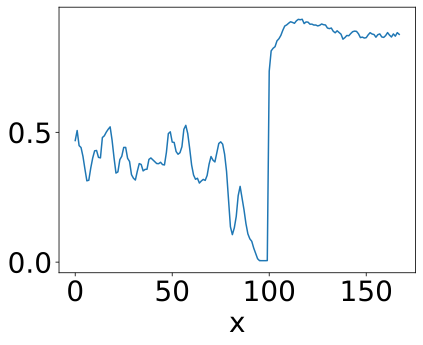

In [208]:
#Local Minima
BasinTopo=zdataset.topography__elevation.isel(x=slice(int(wb/CellSize),-1))
DownBasinSlope=((BasinTopo.isel(x=slice(0,-2)).values)-(BasinTopo.isel(x=slice(1,-1)).values))/CellSize
BinaryMinima=xr.DataArray(np.where(DownBasinSlope<0.01,1,0),dims=['time','y','x'])
MinimaFrequency=BinaryMinima.sum('y').sum('time')/(len(zdataset.out)-1)/len(zdataset.y)
MinimaFrequency.plot()

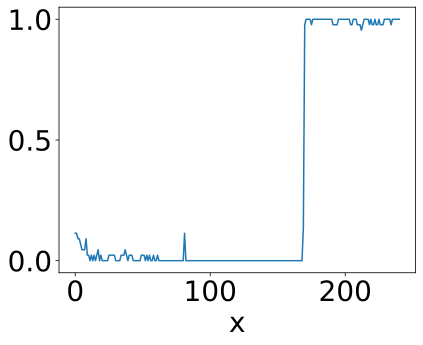

In [209]:
import DominantChannelDynamics as channel



a=xr.DataArray(channel.AvulsionMainChannel(Binary,DominantDrainage_YPath),dims=['time','y','x'])
sumAvulsion_overtimeperiod=a.max('y').isel(time=slice(-int(nout*1/4),-1)).sum('time')
timeInterval_minus1=int(nout*1/4)-1

AvulsionFrequency=sumAvulsion_overtimeperiod/timeInterval_minus1

AvulsionFrequency.plot()

# Stratigraphy

In [174]:
import Stratigraphy

StartBASIN=int(wm/CellSize)
ENDBASIN=-1

#Inputs for stratiProfiles Mean Y
XorY_StratiOverTime=zdataset.strati__elevation.isel(out2=-1).mean('y')#zdataset.strati__elevation.isel(out=-1).isel(y=MidBasin)
XorY_StratiOverTimeMeanY=np.asarray(XorY_StratiOverTime[:,StartBASIN:ENDBASIN])
Time_DistanceGridMeanY=np.asarray(np.tile(np.arange(int(XorY_StratiOverTimeMeanY.shape[1])), (int(XorY_StratiOverTimeMeanY.shape[0]), 1)))
XorY_GrainSizeOverTimeMeanY=np.asarray(zdataset.erosion__rate.mean('y')[:,StartBASIN:ENDBASIN])
# Strati function
StratiGS_LongProfileOverTimeMeanY=Stratigraphy.plotStratigraphy(XorY_StratiOverTimeMeanY,XorY_GrainSizeOverTimeMeanY)

In [184]:
np.shape(XorY_StratiOverTimeMeanY)

(181, 70)

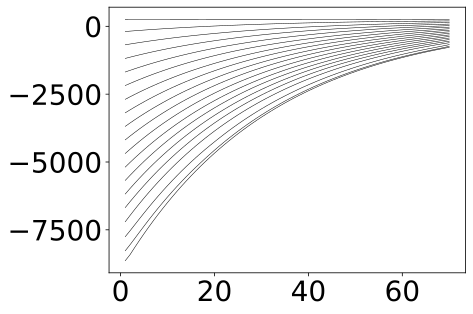

In [191]:
for step in range(0,len(zdataset.out),10):
    plt.plot(a,XorY_StratiOverTimeMeanY[step,:],color='k',linewidth=0.5)

In [196]:
fig = plt.figure(figsize=(18, 9))
a=np.arange(1,len(zdataset.x.isel(x=slice(StartBASIN,ENDBASIN)))+1)
plt.pcolormesh(Time_DistanceGridMeanY[:],XorY_StratiOverTimeMeanY[:],StratiGS_LongProfileOverTimeMeanY[:],cmap='RdYlBu')

plt.ylabel('Elevation (m)')
bottom=int(XorY_StratiOverTimeMeanY.min()-XorY_StratiOverTimeMeanY.max())
plt.ylim(bottom,250)
plt.xlabel('Downstream Distance (m)')
cbar=plt.colorbar()
cbar.set_label('Deposition/Erosion Rate m/yr', rotation=270, labelpad=50)
plt.clim(-0.0004,0.0004)
plt.rcParams.update({'font.size': 28})
#plt.savefig("ER_FlexureBest.pdf", format="pdf", bbox_inches="tight")

/var/folders/tb/39mwj8zx55l80qbywxxv98nm0000gp/T/ipykernel_74303/1219548741.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Time_DistanceGridMeanY[:],XorY_StratiOverTimeMeanY[:],StratiGS_LongProfileOverTimeMeanY[:],cmap='RdYlBu')


# Without subsidence

In [201]:
# Uplift
s0=0
u0=0.00035# 0.0001666-0.0003333 (one to two thirds the subsidence rate)
alpha=2.2 #2-2.5 #increase alpha since I made the basin longer
U = xr.DataArray(np.where(x<wm, u0, -s0*np.exp(-(x-wm)/wb*alpha)),dims=['y','x'])

In [202]:
# %create_setup model --default --verbose
import xsimlab as xs

ds_in = xs.create_setup(
    model=model,
    clocks={'time': np.linspace(0,tf,ntime),
           'out': np.linspace(0,tf,nout),
            'out2': np.linspace(tf-timestepbtw_output,tf,1)},
    master_clock = 'time',
    input_vars={
        # nb. of grid nodes in (y, x)
        'grid__shape': [ny,nx],
        # total grid length in (y, x)
        'grid__length': [yl,xl],
        # node status at borders
        'boundary__status': Boundary,
        # uplift rate
        'uplift__rate': U,
        # MFD partioner slope exponent
        'flow__slope_exp': 1.0,
        # drainage area exponent
        'spl__area_exp': 0.4,
        # slope exponent
        'spl__slope_exp': 1,
        # relative tolerance (Gauss-Siedel convergence)
        'spl__tol_rel': 0.0001,
        # absolute tolerance (Gauss-Siedel convergence)
        'spl__tol_abs': 0.0001,
        # max nb. of iterations (Gauss-Siedel convergence)
        'spl__max_iter': 100,
        # bedrock channel incision coefficient
        'spl__k_coef_bedrock': 1.5e-5,
        # soil (sediment) channel incision coefficient
        'spl__k_coef_soil': 2e-5, #higher k_f is generally more erodible. 
        # detached bedrock transport/deposition coefficient
        'spl__g_coef_bedrock': 0.7, #transport limited (G over 0.4 with sufficient sediment). Mediam 0.7 from Guerit et al. (2019)?
        # soil (sediment) transport/deposition coefficient
        'spl__g_coef_soil': 1,
        # bedrock diffusivity
        'diffusion__diffusivity_bedrock': 3e-2, #varies depends on your spatial grid resolution! This will change your slopes between the channels in the mountain area. 
        #3e-3 m^2yr^1 at the 10 m scale. Bump up diffusitivty coefficent an order of magnitude for each change in grid magnitude. Cell=100m then diffusivity=3e-2.
        # soil (sediment) diffusivity
        'diffusion__diffusivity_soil': 3e-2,
        # surface topography elevation
        'topography__elevation': h0,
        'strati__freeze_time': np.linspace(0,tf,nout),
        'gsize__D0': 1, 
        # The bedrock source grain size standard deviation
        'gsize__SD0': 0.75,
        # Cv (grain size calculation constant) described in Fedele and Paola (2007) and Duller
        # et al. (2010)
        'gsize__Cv': 0.75,
        # C1 (grain size calculation constant) described in Fedele and Paola (2007) and Duller
        # et al. (2010)
        'gsize__C1': 0.75,
        # Porosity
        'gsize__porosity': 0,
        
        
    },
    output_vars={'topography__elevation': 'out',
                 'bedrock__elevation': 'out',
                 'drainage__flowacc': 'out',
                 'erosion__rate': 'out',
                 'gsize__EFlux': 'out',
                 'gsize__Age': 'out',
                 "strati__elevation": "out2", #only need the final time step
                }
)


In [203]:
zgroup = zarr.group("DeathValleyMountain_s0.zarr", overwrite=True)

In [212]:
with model, xs.monitoring.ProgressBar():
    ds_out = (ds_in.xsimlab.run(model=model, store=zgroup))

             0% | initialize 

In [213]:
zdataset = xr.open_zarr('DeathValleyMountain_s0.zarr').set_index()

In [216]:
#Take a look at basin 2
from ipyfastscape import TopoViz3d

app = TopoViz3d(zdataset.isel(x=slice(int(wm/CellSize),-1)), canvas_height=600, time_dim="out")

app.components['background_color'].set_color('lightgray')
app.components['vertical_exaggeration'].set_factor(5)
app.components['timestepper'].go_to_time(zdataset.isel(x=slice(int(wm/CellSize),-1)).out[-1])

app.show()

/Users/awild/opt/anaconda3/envs/workshop-itn-potsdam-2023-01/lib/python3.10/site-packages/ipyfastscape/xr_accessor.py:73: FutureWarning: Passing method to Float64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  return self._dataset.indexes[self.time_dim].get_loc(time, method='nearest')


Output(layout=Layout(height='640px'))

In [214]:
import Stratigraphy

StartBASIN=int(wm/CellSize)
ENDBASIN=-1

#Inputs for stratiProfiles Mean Y
XorY_StratiOverTime=zdataset.strati__elevation.isel(out2=-1).mean('y')#zdataset.strati__elevation.isel(out=-1).isel(y=MidBasin)
XorY_StratiOverTimeMeanY=np.asarray(XorY_StratiOverTime[:,StartBASIN:ENDBASIN])
Time_DistanceGridMeanY=np.asarray(np.tile(np.arange(int(XorY_StratiOverTimeMeanY.shape[1])), (int(XorY_StratiOverTimeMeanY.shape[0]), 1)))
XorY_GrainSizeOverTimeMeanY=np.asarray(zdataset.erosion__rate.mean('y')[:,StartBASIN:ENDBASIN])
# Strati function
StratiGS_LongProfileOverTimeMeanY=Stratigraphy.plotStratigraphy(XorY_StratiOverTimeMeanY,XorY_GrainSizeOverTimeMeanY)

In [217]:
fig = plt.figure(figsize=(18, 9))
a=np.arange(1,len(zdataset.x.isel(x=slice(StartBASIN,ENDBASIN)))+1)
plt.pcolormesh(Time_DistanceGridMeanY[:],XorY_StratiOverTimeMeanY[:],StratiGS_LongProfileOverTimeMeanY[:],cmap='RdYlBu')

plt.ylabel('Elevation (m)')
bottom=int(XorY_StratiOverTimeMeanY.min()-XorY_StratiOverTimeMeanY.max())
#plt.ylim(bottom,250)
plt.xlabel('Downstream Distance (m)')
cbar=plt.colorbar()
cbar.set_label('Deposition/Erosion Rate m/yr', rotation=270, labelpad=50)
plt.clim(-0.0004,0.0004)
plt.rcParams.update({'font.size': 28})
#plt.savefig("ER_FlexureBest.pdf", format="pdf", bbox_inches="tight")

/var/folders/tb/39mwj8zx55l80qbywxxv98nm0000gp/T/ipykernel_74303/189131103.py:3: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  plt.pcolormesh(Time_DistanceGridMeanY[:],XorY_StratiOverTimeMeanY[:],StratiGS_LongProfileOverTimeMeanY[:],cmap='RdYlBu')
